In [ ]:
#Importing all the packages for the required functionalities

import warnings
warnings.filterwarnings('ignore')
#importing numpy library
import numpy as np
#importing pandas library
import pandas as pd
#importing seaborn library
import seaborn as sns
#imorting matplotlib library
import matplotlib.pyplot as plt
#Importing Library for train test split
from sklearn.model_selection import train_test_split
from string import punctuation
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization,Dropout,Dense,Multiply,Flatten
from tensorflow.keras.layers import LSTM
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
#Mounting the drive to import the dataset, and the word embedding files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Reading csv file of Question Pair Dataset Available publically
Quora_questions = pd.read_csv("//content//drive//MyDrive//questions.csv")
print("Number of data points:",Quora_questions.shape[0])

Number of data points: 404351


In [ ]:
#Splitting the dataset 
train,test = train_test_split(Quora_questions, test_size=0.33, random_state=42)
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
181139,181139,357761,357762,What is the most interesting Road Trip Story y...,What are the best road trip songs?,0
284223,284223,558625,558626,How do I install a custom Rom in Spice mettle ...,How do I install a custom ROM in my rooted phone?,0
314840,314840,617874,617875,Has sugar hill gang's rapper's delight ever be...,"What is the translation of the word ""by"" to Fr...",0
337099,337099,660891,660892,How do I study math?,How should I study math?,1
84444,84444,167712,167713,Which mobile development companies are based i...,Top mobile app companies in Miami Florida?,1


In [ ]:
#Getting to  know the information regarding the dataset
Quora_questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404351 entries, 0 to 404350
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404351 non-null  int64 
 1   qid1          404351 non-null  int64 
 2   qid2          404351 non-null  int64 
 3   question1     404350 non-null  object
 4   question2     404349 non-null  object
 5   is_duplicate  404351 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


array([0, 0, 0, ..., 0, 0, 0])

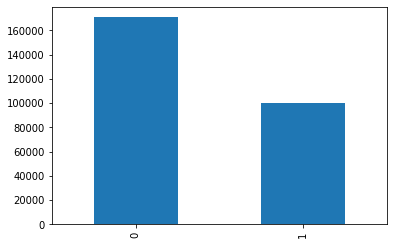

In [ ]:
#check the total questions that are duplicate as per is_dupliacte column and other way round. For TRAINING SET
train['is_duplicate'].value_counts().plot.bar()

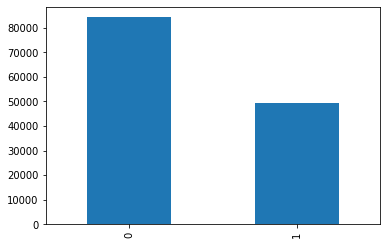

In [ ]:
#check the total questions that are duplicate as per is_dupliacte column and other way round. For TESTING SET
test['is_duplicate'].value_counts().plot.bar()

In [ ]:
#Dropping all the na values present in the training and testing set if any
train.isna().values.any()
train.dropna(inplace=True,axis=0)

test.isna().values.any()
test.dropna(inplace=True,axis=0)
print(len(train))

270912


In [ ]:
'''converting the train and testing question pairs to list of questions that will be passed on to the lstm models after data cleaning,
preprocessing, and embedding it with different embedding models'''

train_q1=pd.Series(train.question1.tolist())
train_q2=pd.Series(train.question2.tolist())
test_q1=pd.Series(test.question1.tolist())
test_q2=pd.Series(test.question2.tolist())
train_q1[:5]
print(len(train_q1))

270912


In [ ]:
'''Function that basically performs the cleaning steps using the regex expressions namely lowering the case, substituting short forms to their base meaningful forms, removing
the special symbols,and removal of stopwords.'''

def cleaning_text(q):
    cleaned_text=[]
    for text in q:
        text = text.lower()

        pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
        text = pattern.sub('', text)
        text = re.sub(r"i'm", "i am", text)
        text = re.sub(r"he's", "he is", text)
        text = re.sub(r"she's", "she is", text)
        text = re.sub(r"that's", "that is", text)        
        text = re.sub(r"what's", "what is", text)
        text = re.sub(r"where's", "where is", text) 
        text = re.sub(r"\'ll", " will", text)  
        text = re.sub(r"\'ve", " have", text)  
        text = re.sub(r"\'re", " are", text)
        text = re.sub(r"\'d", " would", text)
        text = re.sub(r"\'ve", " have", text)
        text = re.sub(r"won't", "will not", text)
        text = re.sub(r"don't", "do not", text)
        text = re.sub(r"did't", "did not", text)
        text = re.sub(r"can't", "can not", text)
        text = re.sub(r"it's", "it is", text)
        text = re.sub(r"couldn't", "could not", text)
        text = re.sub(r"have't", "have not", text)

        text = re.sub(r"[,.\"!@#$%^&*(){}?/;`~:<>+=-]", "", text)
        tokens = word_tokenize(text)
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        stop_words.discard("not")
        words = [w for w in words if not w in stop_words]
        words = ' '.join(words)
        cleaned_text.append(words)
    return cleaned_text


In [ ]:
''' defining the lemmatization function that will return the lemmatized string'''
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
wordnet = WordNetLemmatizer()

def lemma(q1):
    Lemmatized=[]
    for sentences in q1:
        tokens = word_tokenize(sentences)
#         print(tokens)
        # Lemmatization of words
        
        
        lemmatized_output = ' '.join([wordnet.lemmatize(w,pos='v') for w in tokens])
        Lemmatized.append(lemmatized_output)
    return Lemmatized

In [ ]:
#storing the cleaned data
cleaned_train_q1=cleaning_text(train_q1)
cleaned_train_q2=cleaning_text(train_q2)
cleaned_test_q1=cleaning_text(test_q1)
cleaned_test_q2=cleaning_text(test_q2)

In [ ]:
#storing the lemmatized question pairs:
final_train_q1=lemma(cleaned_train_q1)
final_train_q2=lemma(cleaned_train_q2)
final_test_q1=lemma(cleaned_test_q1)
final_test_q2=lemma(cleaned_test_q2)

In [ ]:
'''storing all the labels for training and testing set'''
train_labels=train['is_duplicate'].values
test_labels=test['is_duplicate'].values

270912
133436


In [ ]:
'''calculating the maximum length of questions after padding'''
max_seq_length=0
for i in final_train_q1:
  max_seq_length=len(i.split(' ')) if len(i.split(' '))>max_seq_length else max_seq_length
print(max_seq_length)

53


In [ ]:
#Using the keras tokenizer module to tokenize the lemmatized sequences and pad them accordingly
tokenizer = Tokenizer(num_words=200000)
tokenizer.fit_on_texts(final_train_q1+final_train_q2)

tr_q1 = tokenizer.texts_to_sequences(final_train_q1)
tr_q1 = pad_sequences(tr_q1, maxlen =54, padding='post')

# tokenizer.fit_on_texts(final_train_q2)
tr_q2 = tokenizer.texts_to_sequences(final_train_q2)
tr_q2 = pad_sequences(tr_q2, maxlen = 54, padding='post')


test_q1 = tokenizer.texts_to_sequences(final_test_q1)
test_q1 = pad_sequences(test_q1, maxlen = 54, padding='post')

test_q2 = tokenizer.texts_to_sequences(final_test_q2)
test_q2 = pad_sequences(test_q2, maxlen = 54, padding='post')


In [ ]:
#calculating the total words in the vocabulary
total_words=tokenizer.word_index

270912 270912 270912


### **Importing the Glove pretrained model and embedding the Question Sequences**

In [ ]:
embedding_index = {}
with open('//content//drive//MyDrive//glove.6B.200d.txt','r',encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], 'float32')
        embedding_index[word] = vectors
    f.close()

In [ ]:
embedding_matrix = np.random.random((len(total_words)+1, 200))
for word, i in total_words.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
#Deifintion of the attention class to update the weights and bias for the attention layer
from keras.layers import Layer
import keras.backend as K
class attention(Layer):
    def __init__(self,**kwargs):
      super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
      print(input_shape)
      self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
      self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
      super(attention, self).build(input_shape)

    def call(self,x):
      et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
      at=K.softmax(et)
      at=K.expand_dims(at,axis=-1)
      output=x*at
      return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
      return (input_shape[0],input_shape[-1])

    def get_config(self):
      return super(attention,self).get_config()

In [ ]:
#Defining the Manhattan distance function
def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

In [ ]:
# Model structure for both the input questions
left_input_att = tf.keras.layers.Input(shape=(54,), dtype='int32')
right_input_att = tf.keras.layers.Input(shape=(54,), dtype='int32')

embedding_layer_att = tf.keras.layers.Embedding(input_dim = len(total_words)+1,\
                       output_dim = 200,weights = [embedding_matrix],\
                      input_length = 54)

# Embedded version of the inputs
encoded_left_att = embedding_layer_att(left_input_att)
encoded_right_att = embedding_layer_att(right_input_att)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm_att_in=LSTM(128,return_sequences=True)

left_output_att = attention()(shared_lstm_att_in(encoded_left_att))
right_output_att = attention()(shared_lstm_att_in(encoded_right_att))


# merged = Multiply()([left_output_att, right_output_att])

# merged = Flatten()(merged)
# merged = Dense(100, activation = 'relu')(merged)
# merged = Dropout(0.2)(merged)
# merged = Dense(50, activation = 'relu')(merged)
# merged = Dropout(0.2)(merged)
# merged = Dense(2, activation = 'sigmoid')(merged)
# Calculates the distance as defined by the MaLSTM model

malstm_distance_att = tf.keras.layers.Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([left_output_att, right_output_att])

# # # Pack it all up into a model
malstm_att = Model([left_input_att, right_input_att],[malstm_distance_att])

malstm_att.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
# malstm_att.summary()

from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('model-{epoch:03d}-{val_accuracy:03f}.h5', verbose=1, monitor='val_accuracy',save_best_only=True, mode='auto')

malstm_trained_att = malstm_att.fit([tr_q1, tr_q2], train_labels, batch_size=1000, epochs=10,validation_data=([test_q1,test_q2], test_labels), callbacks=[checkpoint], verbose=1)

(None, 54, 128)
(None, 54, 128)
Epoch 1/10
271/271 [==============================] - 98s 236ms/step - loss: 0.1855 - accuracy: 0.7102 - val_loss: 0.1549 - val_accuracy: 0.7814

Epoch 00001: val_accuracy improved from -inf to 0.78139, saving model to model-001-0.781386.h5
Epoch 2/10
271/271 [==============================] - 62s 231ms/step - loss: 0.1408 - accuracy: 0.8040 - val_loss: 0.1399 - val_accuracy: 0.8034

Epoch 00002: val_accuracy improved from 0.78139 to 0.80337, saving model to model-002-0.803366.h5
Epoch 3/10
271/271 [==============================] - 62s 230ms/step - loss: 0.1211 - accuracy: 0.8362 - val_loss: 0.1356 - val_accuracy: 0.8111

Epoch 00003: val_accuracy improved from 0.80337 to 0.81115, saving model to model-003-0.811145.h5
Epoch 4/10
271/271 [==============================] - 62s 230ms/step - loss: 0.1083 - accuracy: 0.8560 - val_loss: 0.1331 - val_accuracy: 0.8154

Epoch 00004: val_accuracy improved from 0.81115 to 0.81542, saving model to model-004-0.81542

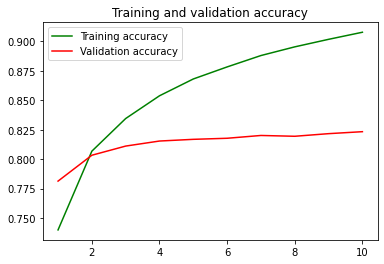

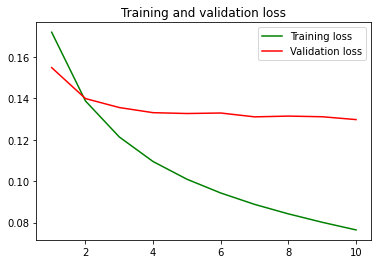

In [ ]:
# Plot results

acc = malstm_trained_att.history['accuracy']
val_acc = malstm_trained_att.history['val_accuracy']
loss = malstm_trained_att.history['loss']
val_loss = malstm_trained_att.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
malstm_att.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 54)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 54)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 54, 200)      14268400    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 54, 128)      168448      embedding[0][0]              

In [ ]:
#loading the model along with the attention layer information
from keras.utils import CustomObjectScope
from keras.models import load_model

with CustomObjectScope({'attention': attention,'attention_1':attention}):
    model1 = load_model('/content/model-010-0.823368.h5')

(None, 54, 128)
(None, 54, 128)


In [ ]:
#Calculating the testing accuracy to check the performance of the model
y_pred = model1.evaluate([test_q1,test_q2],test_labels, batch_size=1000, verbose=1)

134/134 [==============================] - 5s 32ms/step - loss: 0.1298 - accuracy: 0.8234
